In [26]:
import csv
import openai
import os
from openai import OpenAI
import os
import time
import random
import json
import logging
from datetime import datetime
import tqdm
import pickle
import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#replace "API-KEY" with personalized API-KEY
client = OpenAI(api_key=os.environ['CHEN_OPENAI_API_KEY'])

In [7]:
df_master_review = pd.read_csv("/Users/yiquntchen/Desktop/chen-lab/CausalJudge/master-df-get-reviewers.csv").sort_values("pmid_number")

In [8]:
def merge_two_rows(row1, row2):
    merged_row = {}
    for col in row1.index:
        val1 = str(row1[col]).lower() if pd.notna(row1[col]) else np.nan
        val2 = str(row2[col]).lower() if pd.notna(row2[col]) else np.nan
        
        if pd.isna(val1) and not pd.isna(val2):
            merged_row[col] = val2
        elif not pd.isna(val1) and pd.isna(val2):
            merged_row[col] = val1
        elif val1 == val2:
            merged_row[col] = val1
        else:
            merged_row[col] = f"reviewer 1: {val1}; reviewer 2: {val2}"
    return pd.Series(merged_row)

def merge_reviewers(df):
    # Drop unwanted columns
    df = df.drop(columns=["reviewer", "reviewer_1", "reviewer_2", "x40", "source", "reviewer_1_11", "reviewer_2_12"], errors='ignore')
    
    merged_rows = []
    i = 0
    while i < len(df):
        if i + 1 < len(df):
            row1 = df.iloc[i]
            row2 = df.iloc[i+1]
            merged = merge_two_rows(row1, row2)
        else:
            # Last unpaired row, just lowercase it
            merged = df.iloc[i].apply(lambda x: str(x).lower() if pd.notna(x) else np.nan)
        
        # Special handling for link_to_paper and link_to_paper_2
        link1 = row1.get('link_to_paper', np.nan)
        link2 = row1.get('link_to_paper_2', np.nan)
        if pd.isna(link1) or link1.lower() in ['nan', 'none']:
            link1 = link2
        merged['link_to_paper'] = link1.lower() if pd.notna(link1) else np.nan
        
        # Remove link_to_paper_2 column
        if 'link_to_paper_2' in merged:
            merged = merged.drop('link_to_paper_2')
        
        merged_rows.append(merged)
        i += 2
    
    merged_df = pd.DataFrame(merged_rows).reset_index(drop=True)
    return merged_df


In [9]:
merged_df_master_review = merge_reviewers(df_master_review)

In [14]:
merged_df_master_review.to_json("/Users/yiquntchen/Desktop/chen-lab/CausalJudge/merged-master-df-get-reviewers.json",
                               orient='records')

In [15]:
# Open and load JSON manually
with open("/Users/yiquntchen/Desktop/chen-lab/CausalJudge/merged-master-df-get-reviewers.json", 'r') as f:
    merged_json_master_review = json.load(f)

In [18]:
# Open and load JSON manually
with open("/Users/yiquntchen/Dropbox/causaljudge-data/gpt4o_result_final.json", 'r') as f:
    gpt4o_result_final = json.load(f)

In [55]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Canonical names vs actual data keys


In [84]:

def evaluate_binary_predictions_across_records(truth_dict_all, prediction_dict_all, model_name="model"):
    """
    Evaluate binary yes/no fields across multiple records (matched by PMID).
    
    Args:
        truth_dict_all (dict): Mapping from pmid_number to ground truth dict.
        prediction_dict_all (dict): Mapping from pmid_number to model prediction dict.
        model_name (str): Name of the model.
    
    Returns:
        results_df (pd.DataFrame): Table of classification reports per field.
    """
    # List of binary fields (correct spelling only)
    binary_fields = [
        'data_available',
        'clustering',
        'clustering_dealt_with',
        'exposure_randomized',
        'causal_mediation_yes_no',
        'if_baron_kenny_examine_whether_no_interaction_b_w_tx_and_mediator_on_outcome',
        'if_b_k_examine_linear_relationship_b_w_mediator_and_outcome',
        'baseline_value_of_mediator_adjusted_for',
        'baseline_value_of_outcome_adjusted_for',
        'temporal_ordering_of_exposure_before_mediator_yes_no',
        'temporal_ordering_of_mediator_before_outcome_yes_no',
        'discussion_of_mediation_assumptions_yes_no',
        'sensitivity_analyses_to_assumptions_yes_no',
        'does_model_control_for_other_post_exposure_variables_yes_no'
    ]
    
    field_name_mapping = {
    "data_available": "data_available",
    "clustering": "clustering",
    "clustering_dealt_with": "clustering_dealt_with",
    "exposure_randomized": "exposure_randomized",
    "causal_mediation_yes_no": "causal_mediation_yes_no",
    "if_baron_kenny_examine_whether_no_interaction_b_w_tx_and_mediator_on_outcome": "if_baron_kenny_examine_interaction",
    "if_b_k_examine_linear_relationship_b_w_mediator_and_outcome": "if_baron_kenny_examine_linearity",
    "baseline_value_of_mediator_adjusted_for": "baseline_value_of_mediator_adjusted_for",
    "baseline_value_of_outcome_adjusted_for": "baseline_value_of_outcome_adjusted_for",
    "temporal_ordering_of_exposure_before_mediator_yes_no": "temporal_ordering_of_exposure_before_mediator_yes_no",
    "temporal_ordering_of_mediator_before_outcome_yes_no": "temporal_ordering_of_mediator_before_outcome_yes_no",
    "discussion_of_mediation_assumptions_yes_no": "discussion_of_mediation_assumptions_yes_no",
    "sensitivity_analyses_to_assumptions_yes_no": "sensitivity_analyses_to_assumptions_yes_no",
    "does_model_control_for_other_post_exposure_variables_yes_no": "does_model_control_for_other_post_exposure_variables_yes_no",
}
    binary_fields = list(field_name_mapping.keys())

    def normalize_keys(d):
        if d is None:
            return {}  # Important: if prediction is missing, return empty dict
        # Step 1: typo fix
        d_fixed = {k.replace('sensitivity_analyes', 'sensitivity_analyses'): v for k, v in d.items()}
        # Step 2: map key names
        d_mapped = {}
        for std_key, actual_key in field_name_mapping.items():
            if actual_key in d_fixed:
                d_mapped[std_key] = d_fixed[actual_key]
            else:
                d_mapped[std_key] = None  # explicitly missing
        return d_mapped


    # # Normalize typo keys
    # def normalize_keys(d):
    #     return {k.replace('sensitivity_analyes', 'sensitivity_analyses'): v for k, v in d.items()}

    # Collect field-level metrics
    field_results = {}

    # Collect overall labels
    all_gt_labels = []
    all_pred_labels = []

    for field in binary_fields:
        gt_labels = []
        pred_labels = []

        for pmid, truth_entry in truth_dict_all.items():
            truth_entry = normalize_keys(truth_entry)
            prediction_entry = normalize_keys(prediction_dict_all.get(pmid, {}))  # Empty dict if no prediction

            gt = truth_entry.get(field, None)
            pred = prediction_entry.get(field, None)

            if gt is not None:
                gt_labels.append(str(gt).strip().lower())
                pred_labels.append(str(pred).strip().lower() if pred is not None else "none")  # Label missing prediction as "none"

        # Add to global labels
        all_gt_labels.extend(gt_labels)
        all_pred_labels.extend(pred_labels)

        # Field-specific classification report
        if len(gt_labels) > 0:
            report = classification_report(gt_labels, pred_labels, output_dict=True, zero_division=0)
            field_results[field] = {
                "precision_macro": report['macro avg']['precision'],
                "recall_macro": report['macro avg']['recall'],
                "f1_macro": report['macro avg']['f1-score'],
                "accuracy": report['accuracy']
            }

            # Plot confusion matrix per field
            cm = confusion_matrix(gt_labels, pred_labels, labels=list(set(gt_labels + pred_labels)))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(gt_labels + pred_labels)))

            fig, ax = plt.subplots(figsize=(4, 4))
            disp.plot(ax=ax, colorbar=False)
            plt.title(f"Confusion Matrix for {field}\n({model_name})")
            plt.xticks(rotation=45)
            plt.show()

        else:
            field_results[field] = {
                "precision_macro": None,
                "recall_macro": None,
                "f1_macro": None,
                "accuracy": None
            }

    # Global evaluation across all fields
    if len(all_gt_labels) > 0 and len(all_pred_labels) > 0:
        global_report = classification_report(all_gt_labels, all_pred_labels, output_dict=True, zero_division=0)

        print("\n=== Overall Macro Average (Global across all fields) ===")
        print(f"Macro Precision: {global_report['macro avg']['precision']:.3f}")
        print(f"Macro Recall:    {global_report['macro avg']['recall']:.3f}")
        print(f"Macro F1-score:  {global_report['macro avg']['f1-score']:.3f}")

        print("\n=== Overall Weighted Average (Global across all fields) ===")
        print(f"Weighted Precision: {global_report['weighted avg']['precision']:.3f}")
        print(f"Weighted Recall:    {global_report['weighted avg']['recall']:.3f}")
        print(f"Weighted F1-score:  {global_report['weighted avg']['f1-score']:.3f}")
    else:
        print("\nWarning: No ground truth labels collected for global evaluation.")

    # Return field-specific results
    results_df = pd.DataFrame.from_dict(field_results, orient='index')
    results_df.index.name = 'Field'
    results_df.reset_index(inplace=True)

    return results_df


In [85]:
def create_prompt_for_binary_standardization(field_name, merged_value):
    """
    Create a prompt asking the LLM to standardize messy reviewer responses into yes, no, reviewer disagree.
    
    Args:
        field_name (str): Name of the field being cleaned.
        merged_value (str): The messy merged text from reviewers.
    
    Returns:
        prompt (str): The full prompt text to send to the LLM.
    """
    prompt = f"""
You are evaluating the following field: {field_name}.

Here is the information provided by two reviewers (possibly merged):
----
{merged_value}
----

Your task:
- If the two reviewers agree (for instance, no or not; no or not mentioned; or yes and yes with explanations);
or the answer is already yes/no (meaning they have already agreed prior to this step), answer either "yes" or "no".
- If the two reviewers disagree, answer exactly "reviewer disagree".
- You must only respond with **one of**: "yes", "no", or "reviewer disagree".
- Do not explain. Just return the label.

What is the correct standardized answer?
"""
    return prompt.strip()

def standardize_binary_fields(merged_json_master_review, openai_client, model_name="gpt-4o"):
    """
    Standardize only the binary fields of the merged reviewer data using an LLM.
    
    Args:
        merged_json_master_review (list of dicts): Original merged noisy ground truth.
        openai_client: OpenAI client for making completions.
        model_name (str): Model name for the OpenAI call.
    
    Returns:
        standardized_labels (dict): pmid_number -> {field_name -> standardized_label}
    """
    binary_fields = [
        'data_available',
        'clustering',
        'clustering_dealt_with',
        'exposure_randomized',
        'causal_mediation_yes_no',
        'if_baron_kenny_examine_whether_no_interaction_b_w_tx_and_mediator_on_outcome',
        'if_b_k_examine_linear_relationship_b_w_mediator_and_outcome',
        'baseline_value_of_mediator_adjusted_for',
        'baseline_value_of_outcome_adjusted_for',
        'temporal_ordering_of_exposure_before_mediator_yes_no',
        'temporal_ordering_of_mediator_before_outcome_yes_no',
        'discussion_of_mediation_assumptions_yes_no',
        'sensitivity_analyses_to_assumptions_yes_no',
        'does_model_control_for_other_post_exposure_variables_yes_no'
    ]

    # First: re-index by PMID
    truth_dict_all = {entry['pmid_number']: entry for entry in merged_json_master_review}

    standardized_labels = {}

    for pmid, record in tqdm.tqdm(truth_dict_all.items()):
        standardized_labels[pmid] = {}
        for field, merged_value in record.items():
            if field in binary_fields:
                if merged_value:  # only try if there's something
                    prompt = create_prompt_for_binary_standardization(field, merged_value)
                    response = client.chat.completions.create(
                        model=model_name,
                        messages=[{"role": "user", "content": prompt}],
                        temperature=0,
                        max_tokens=10
                    )
                    standardized_label = response.choices[0].message.content.strip().lower()
                    standardized_labels[pmid][field] = standardized_label
                else:
                    standardized_labels[pmid][field] = "none"  # Mark empty as "none"
            else:
                # For non-binary fields: copy the original merged messy text
                standardized_labels[pmid][field] = merged_value

    return standardized_labels

In [46]:
standardized_ground_truth = standardize_binary_fields(
    merged_json_master_review=merged_json_master_review,
    openai_client=client,  # Your OpenAI client instance
    model_name="gpt-4o"
)

100%|█████████████████████████████████████████| 180/180 [21:58<00:00,  7.33s/it]


In [48]:
# Open and load JSON manually
with open("/Users/yiquntchen/Dropbox/causaljudge-data/r12_final_standardized_ground_truth.json", 'w') as f:
    json.dump(standardized_ground_truth,f)

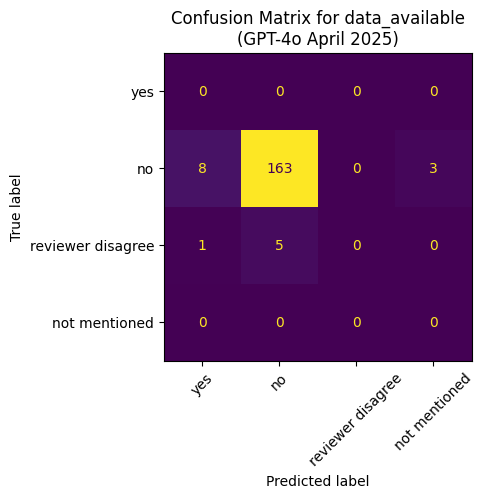

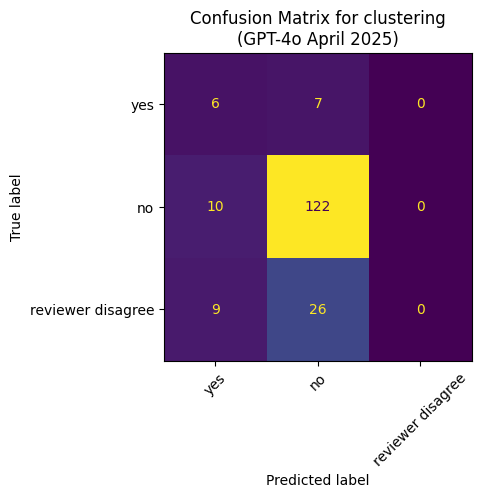

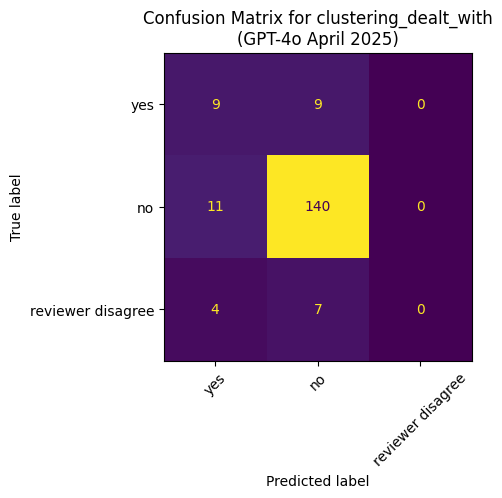

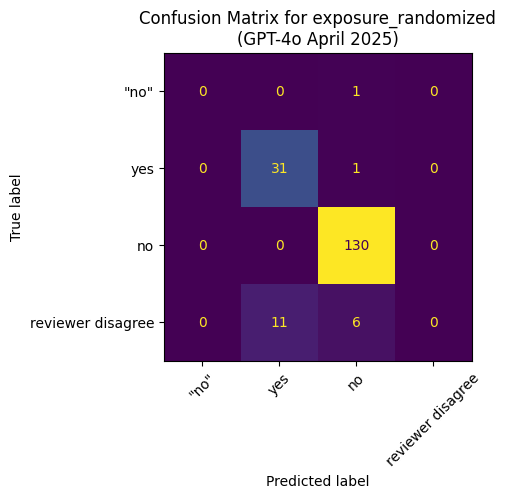

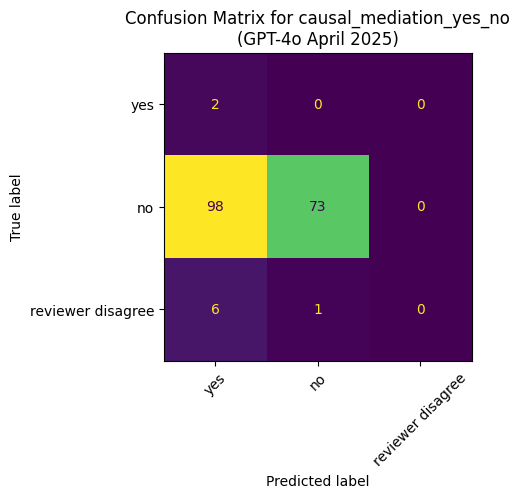

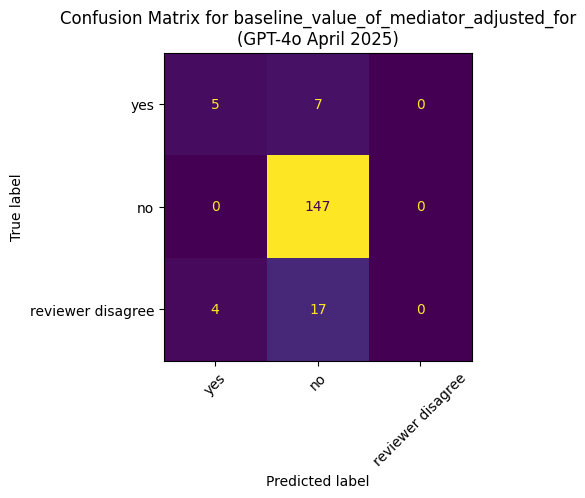

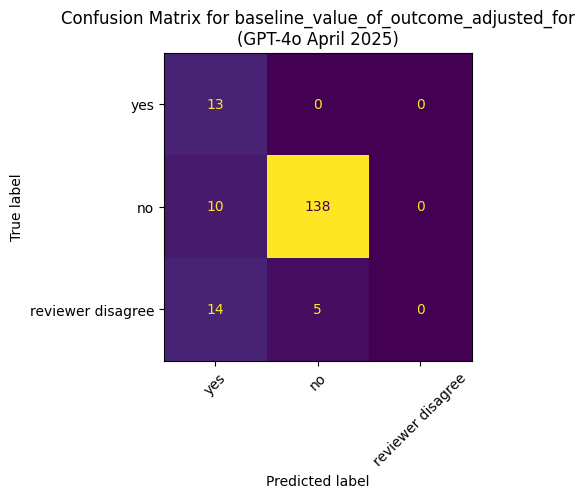

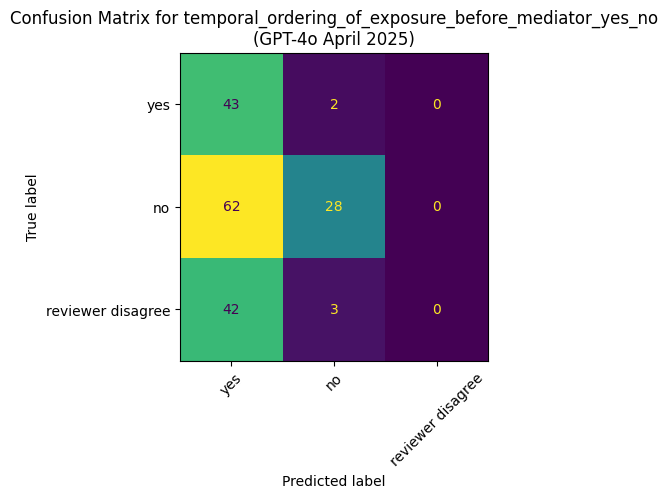

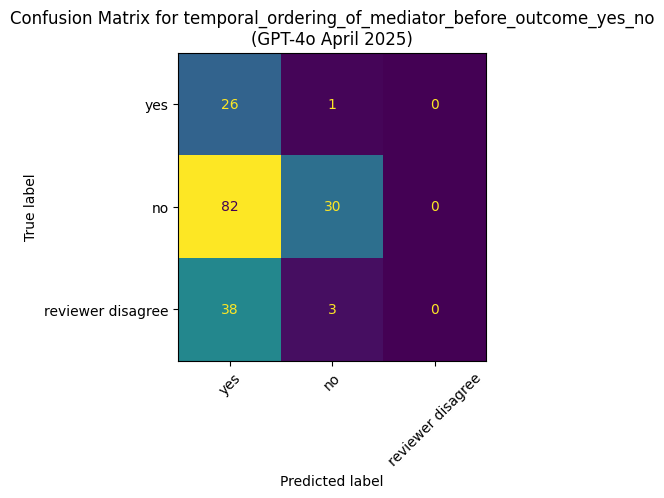

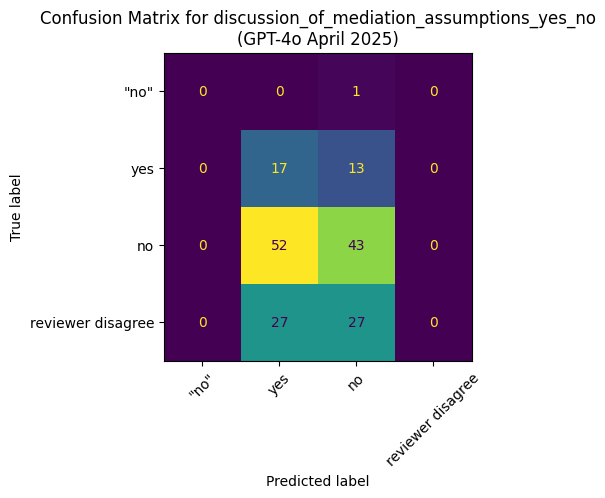

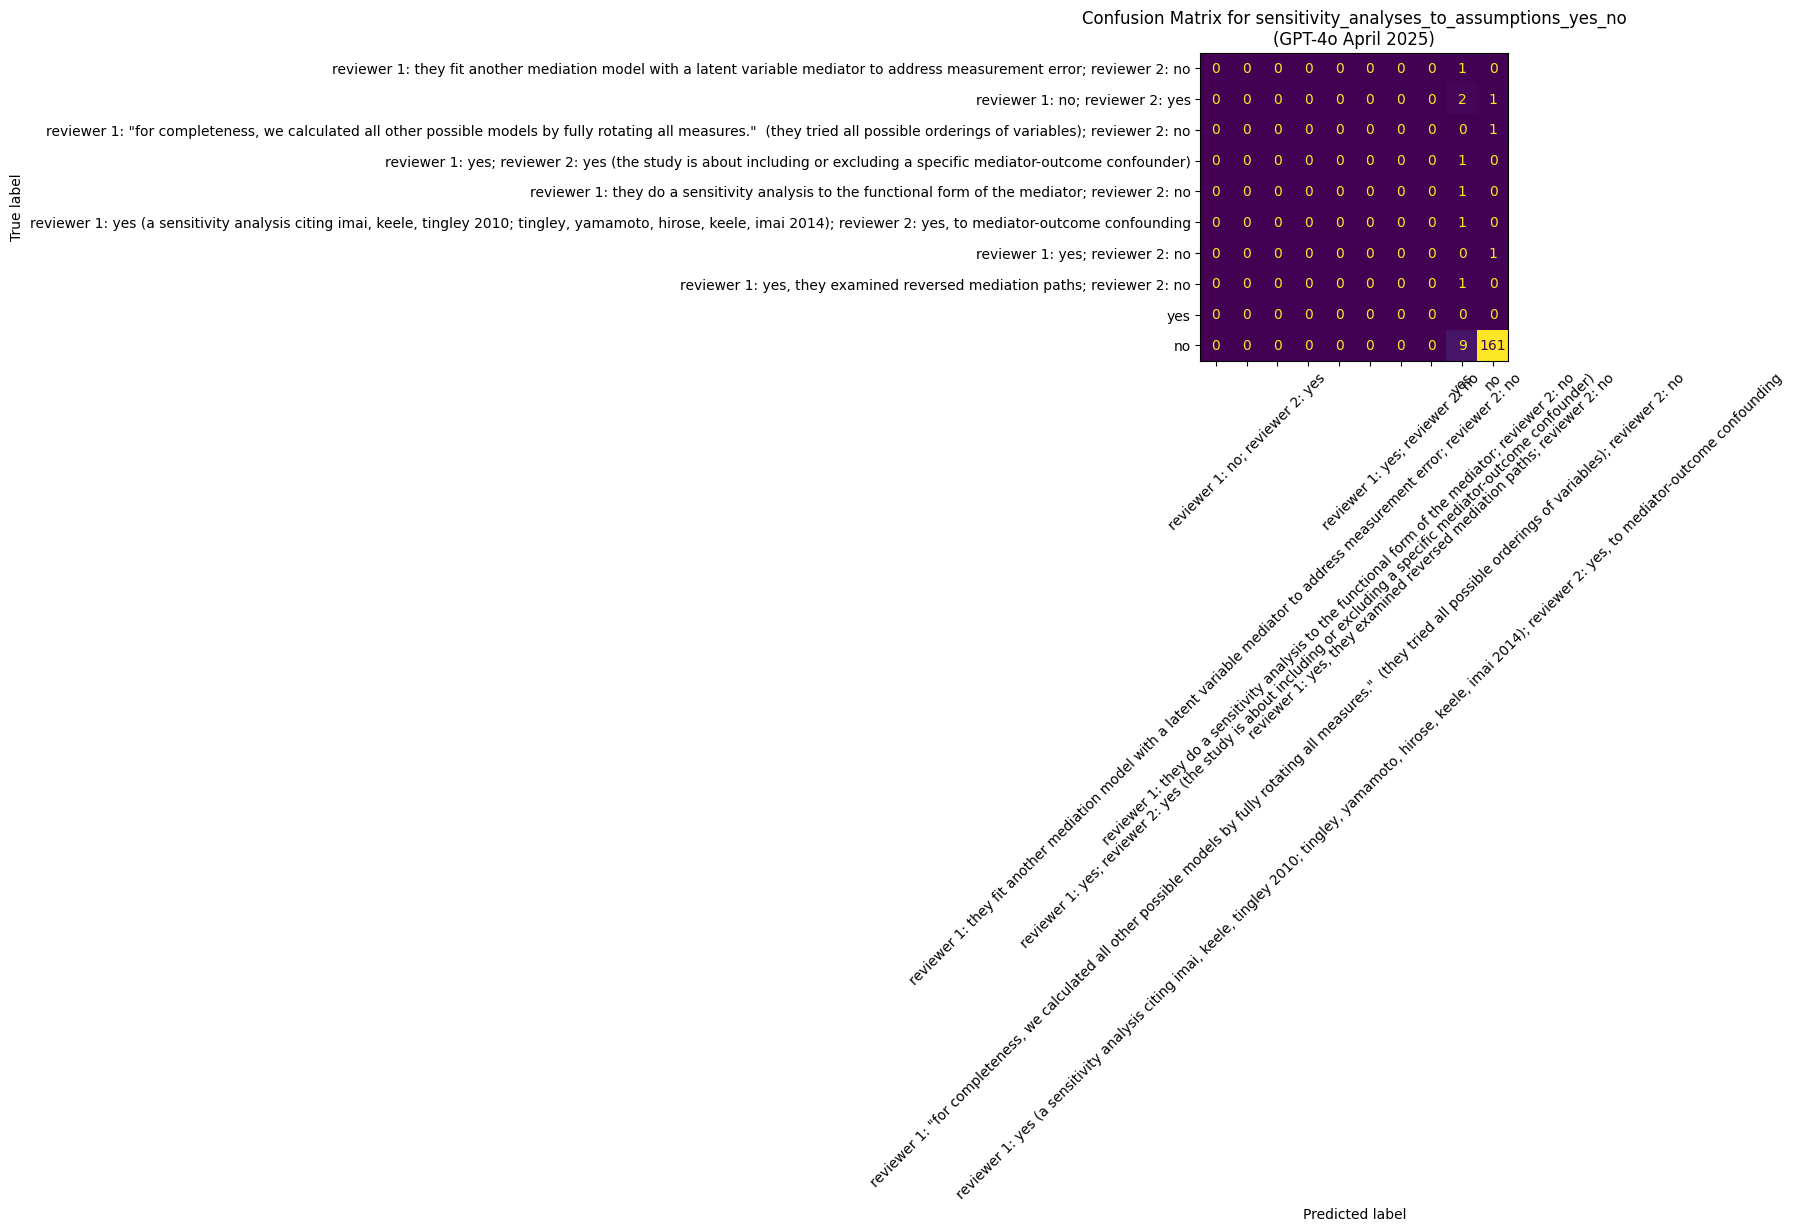

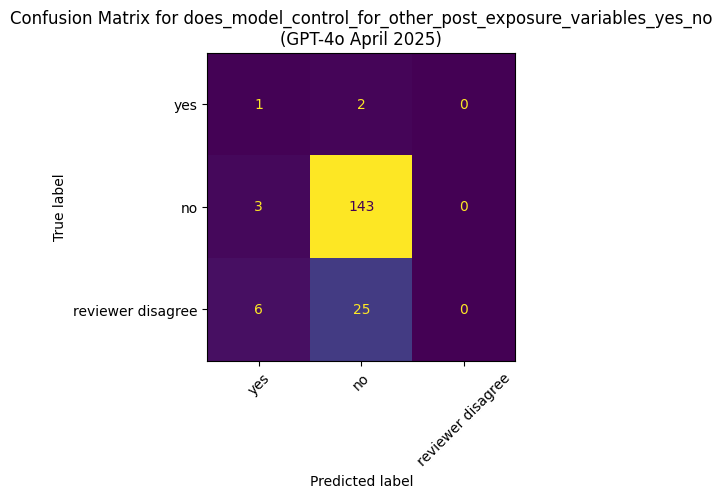


=== Overall Macro Average (Global across all fields) ===
Macro Precision: 0.086
Macro Recall:    0.121
Macro F1-score:  0.092

=== Overall Weighted Average (Global across all fields) ===
Weighted Precision: 0.703
Weighted Recall:    0.681
Weighted F1-score:  0.676


In [68]:
# truth_dict_all: pmid_number -> ground_truth_dict
# prediction_dict_all: pmid_number -> predicted_dict
#truth_dict_all = {entry['pmid_number']: entry for entry in merged_json_master_review}
results_df = evaluate_binary_predictions_across_records(
    truth_dict_all=standardized_ground_truth,
    prediction_dict_all={k: json.loads(v) for k,v in gpt4o_result_final.items()},
    model_name="GPT-4o April 2025"
)

In [69]:
results_df

,Field,precision_macro,recall_macro,f1_macro,accuracy
0,data_available,0.242560,0.234195,0.238304,0.905556
1,clustering,0.342366,0.461927,0.388655,0.711111
2,clustering_dealt_with,0.424145,0.475717,0.446875,0.827778
3,exposure_randomized,0.420031,0.492188,0.451997,0.894444
4,causal_mediation_yes_no,0.335118,0.475634,0.210985,0.416667
5,if_baron_kenny_examine_whether_no_interaction_...,NaN,NaN,NaN,NaN
6,if_b_k_examine_linear_relationship_b_w_mediato...,NaN,NaN,NaN,NaN
7,baseline_value_of_mediator_adjusted_for,0.471735,0.472222,0.466906,0.844444
8,baseline_value_of_outcome_adjusted_for,0.438795,0.644144,0.489485,0.838889
9,temporal_ordering_of_exposure_before_mediator_...,0.380334,0.422222,0.301067,0.394444


In [76]:
results_df_41

,Field,precision_macro,recall_macro,f1_macro,accuracy
0,data_available,0.323529,0.316092,0.319767,0.916667
1,clustering,0.317736,0.452214,0.350528,0.638889
2,clustering_dealt_with,0.405968,0.480991,0.432107,0.800000
3,exposure_randomized,0.237044,0.270124,0.252051,0.872222
4,causal_mediation_yes_no,0.342851,0.590643,0.316302,0.744444
5,if_baron_kenny_examine_whether_no_interaction_...,NaN,NaN,NaN,NaN
6,if_b_k_examine_linear_relationship_b_w_mediato...,NaN,NaN,NaN,NaN
7,baseline_value_of_mediator_adjusted_for,0.278049,0.315306,0.295474,0.850000
8,baseline_value_of_outcome_adjusted_for,0.109828,0.136902,0.081563,0.433333
9,temporal_ordering_of_exposure_before_mediator_...,0.151743,0.162500,0.117937,0.405556


In [87]:
results_df_o4mini

,Field,precision_macro,recall_macro,f1_macro,accuracy
0,data_available,0.194253,0.194253,0.194253,0.938889
1,clustering,0.257068,0.359994,0.291039,0.700000
2,clustering_dealt_with,0.308662,0.351821,0.326073,0.811111
3,exposure_randomized,0.345261,0.387500,0.365090,0.888889
4,causal_mediation_yes_no,0.282684,0.488304,0.305060,0.916667
5,if_baron_kenny_examine_whether_no_interaction_...,NaN,NaN,NaN,NaN
6,if_b_k_examine_linear_relationship_b_w_mediato...,NaN,NaN,NaN,NaN
7,baseline_value_of_mediator_adjusted_for,0.354560,0.456633,0.394812,0.866667
8,baseline_value_of_outcome_adjusted_for,0.339933,0.472323,0.380276,0.861111
9,temporal_ordering_of_exposure_before_mediator_...,0.322657,0.430556,0.352104,0.622222


In [73]:
# Open and load JSON manually
with open("/Users/yiquntchen/Dropbox/causaljudge-data/gpt-4.1-mini_result_final.json", 'r') as f:
    gpt41_result_final = json.load(f)

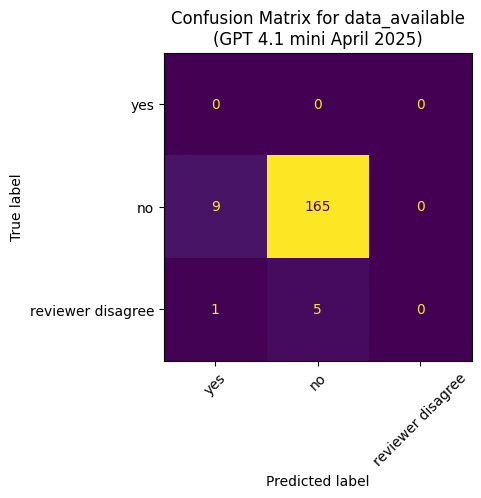

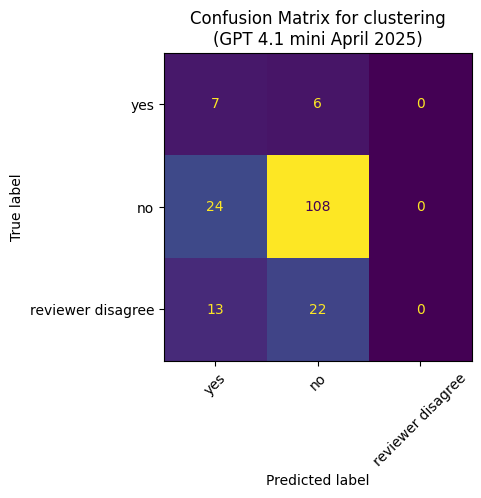

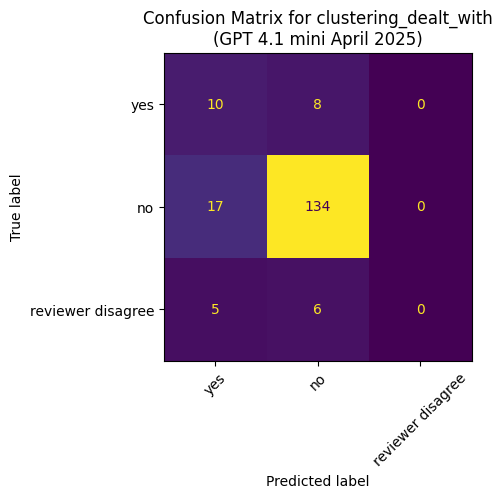

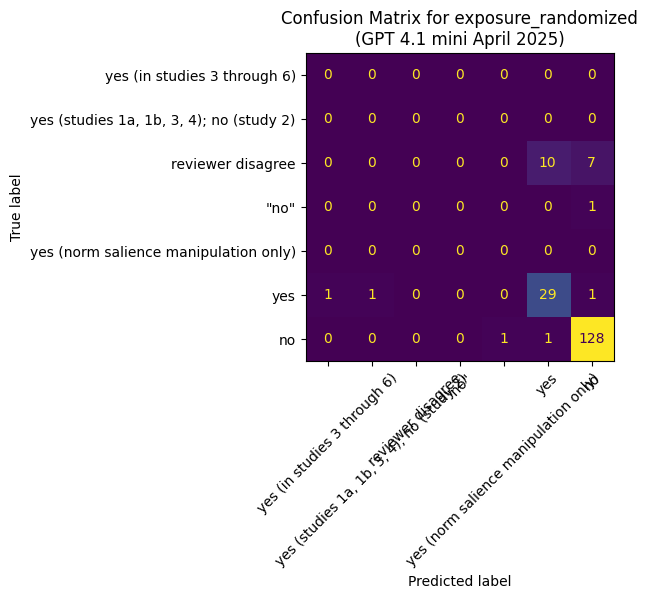

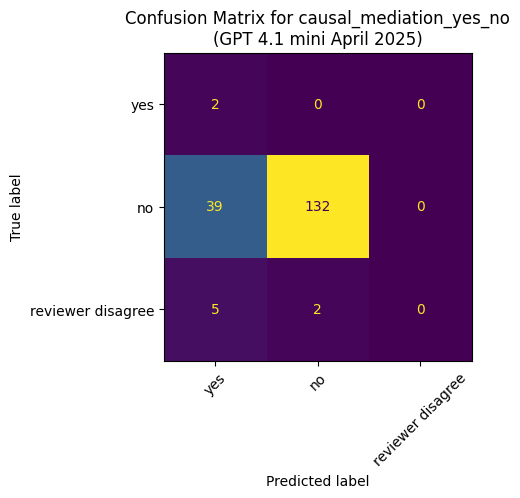

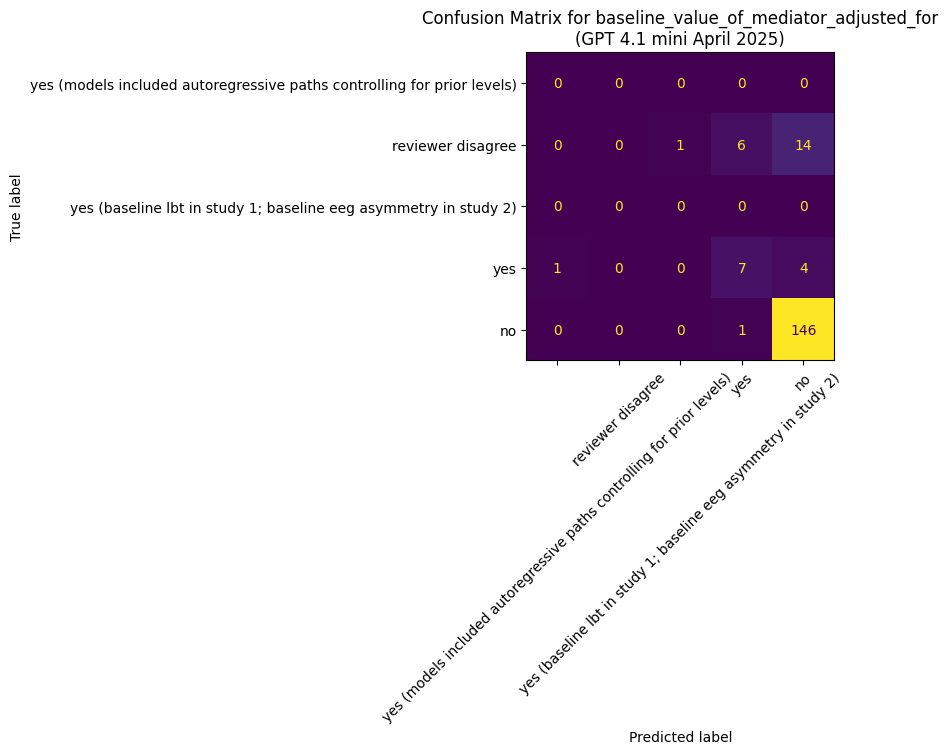

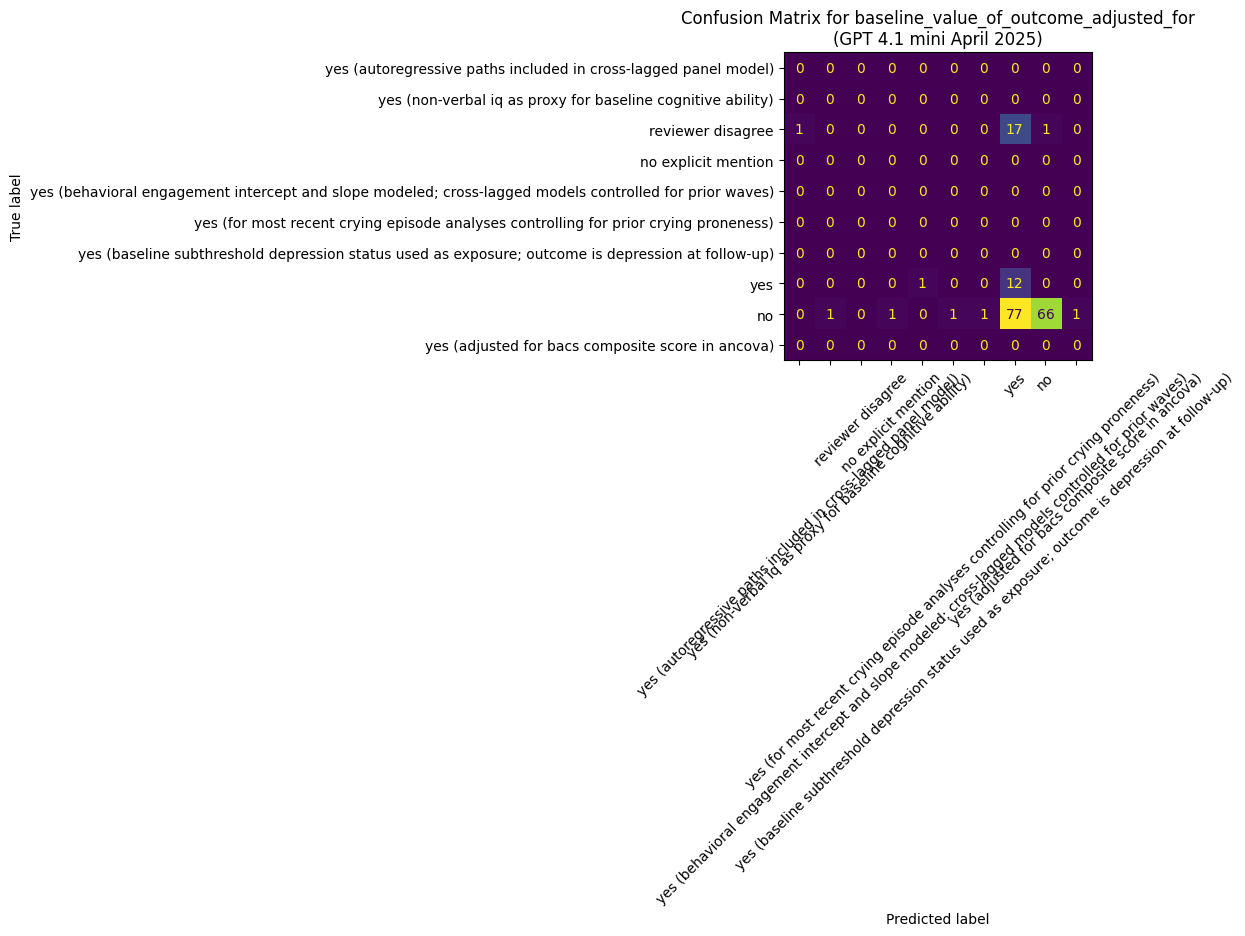

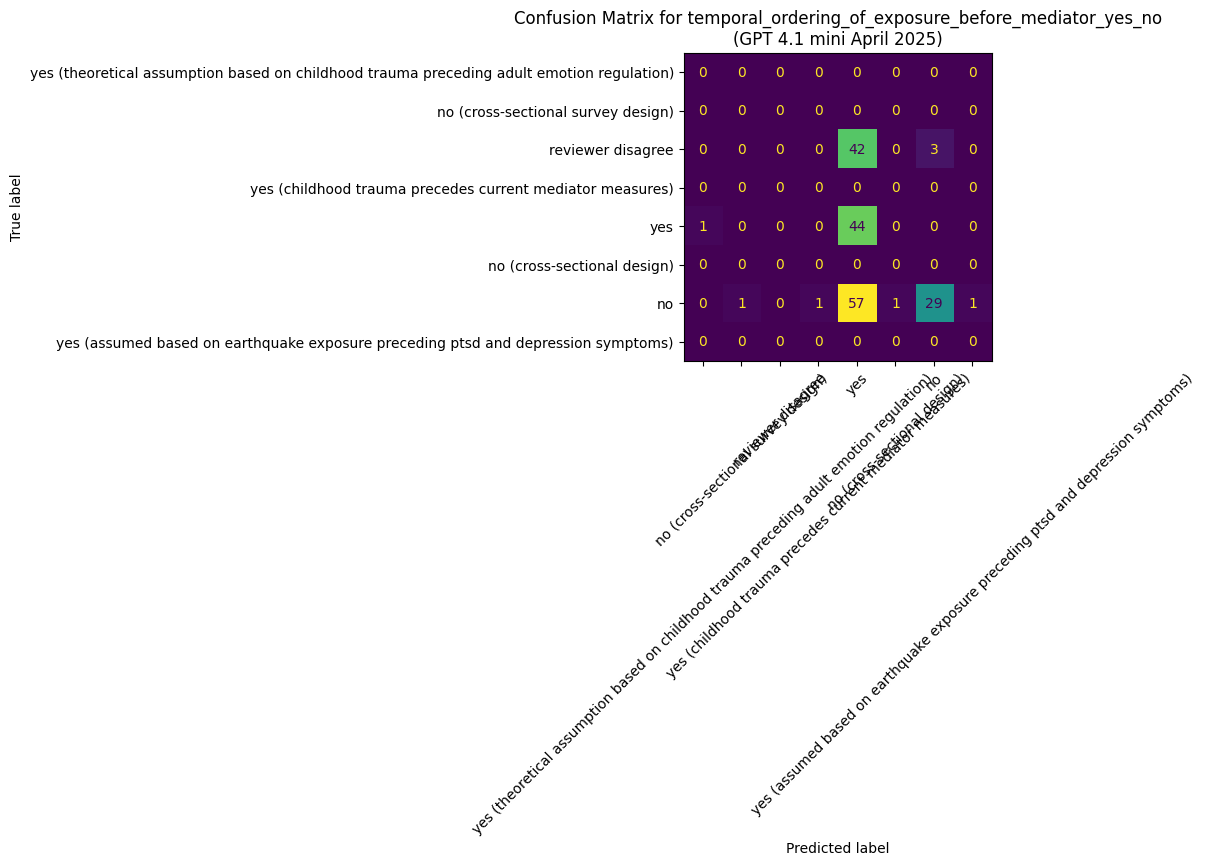

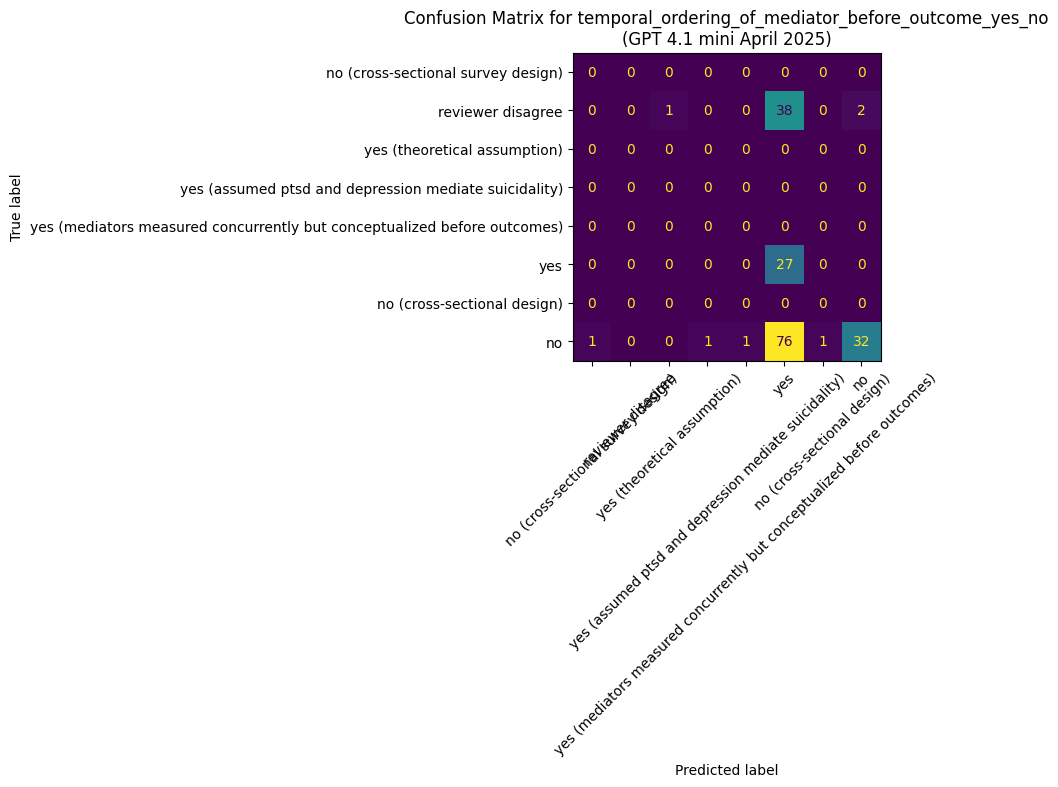

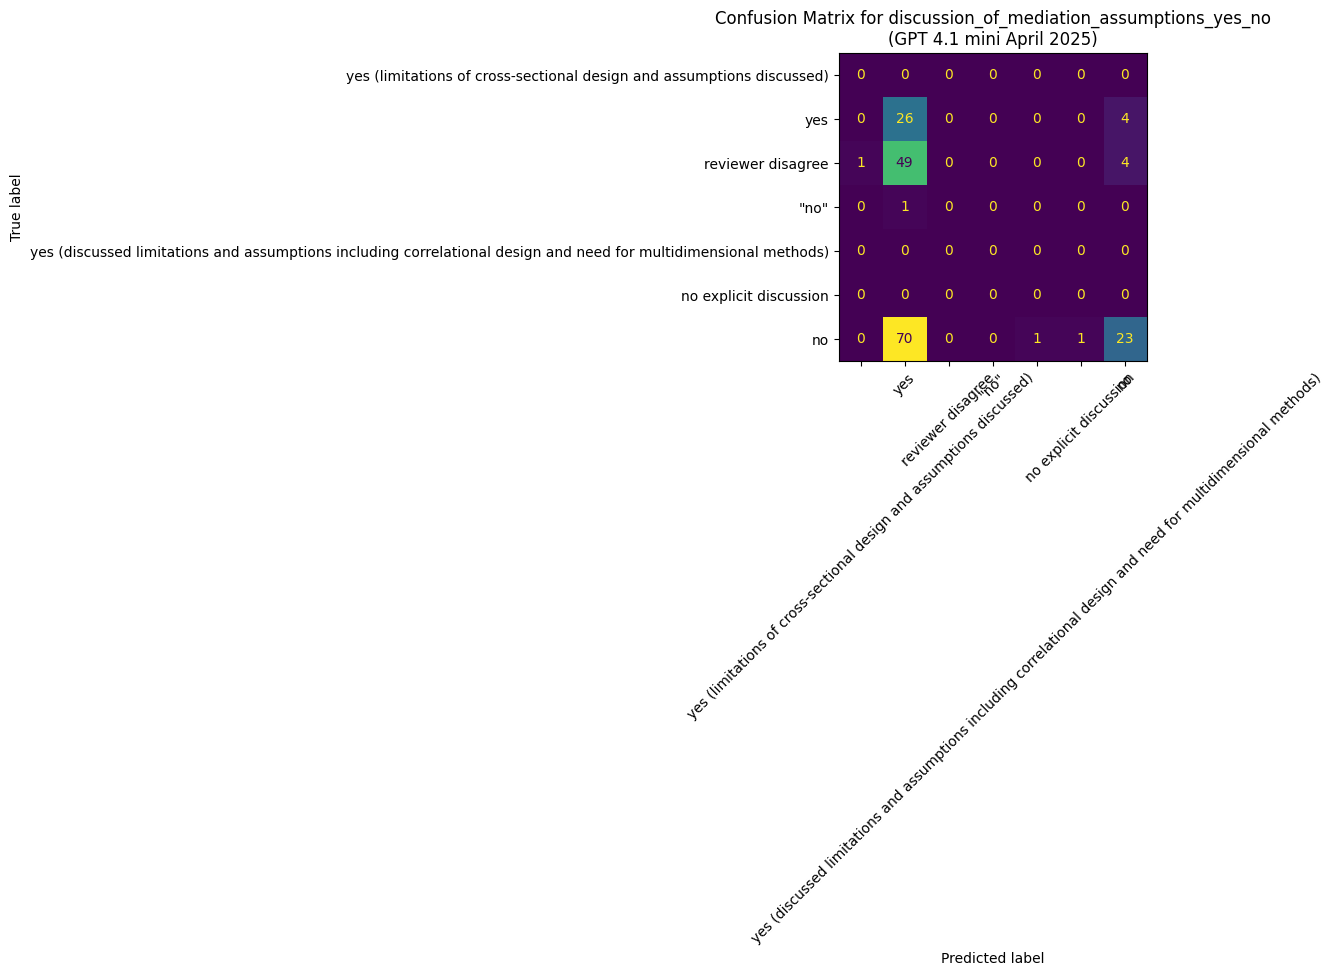

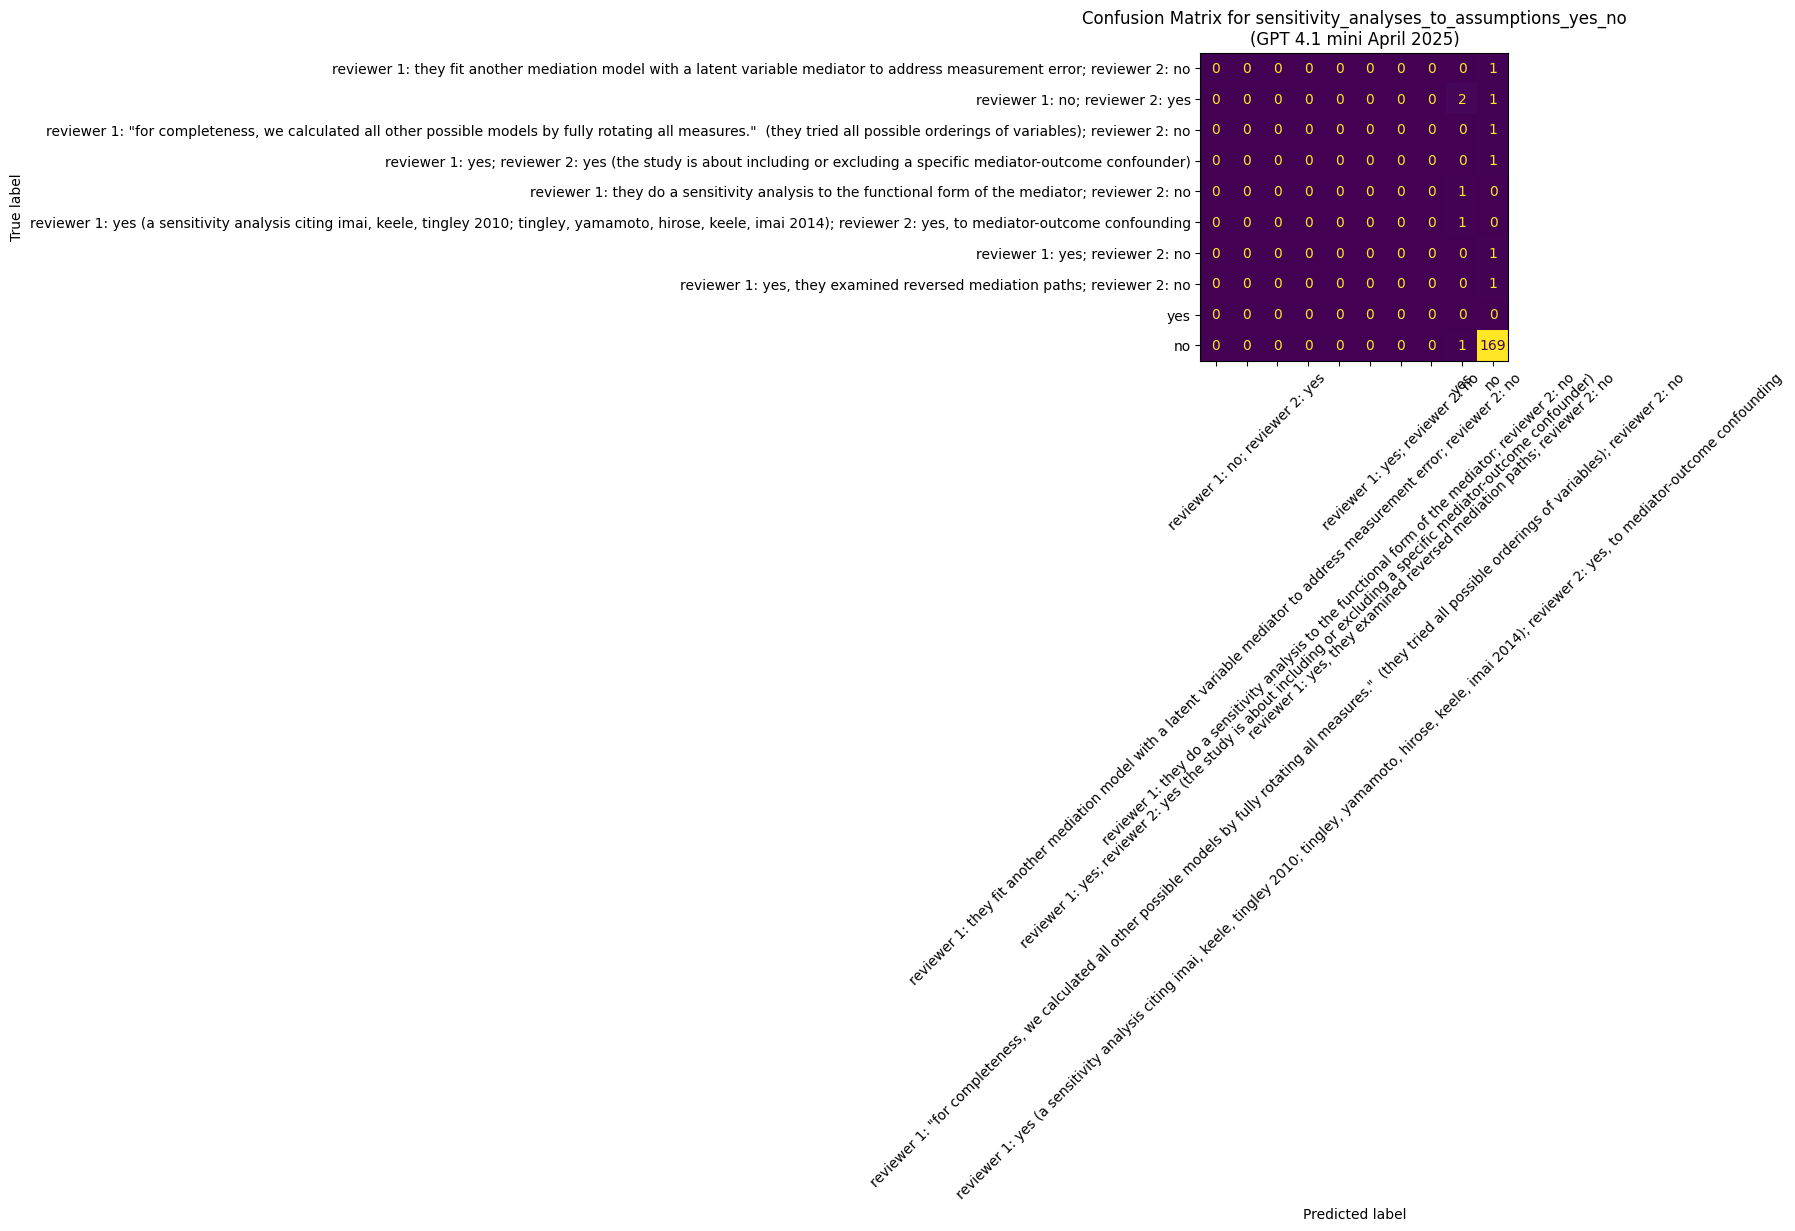

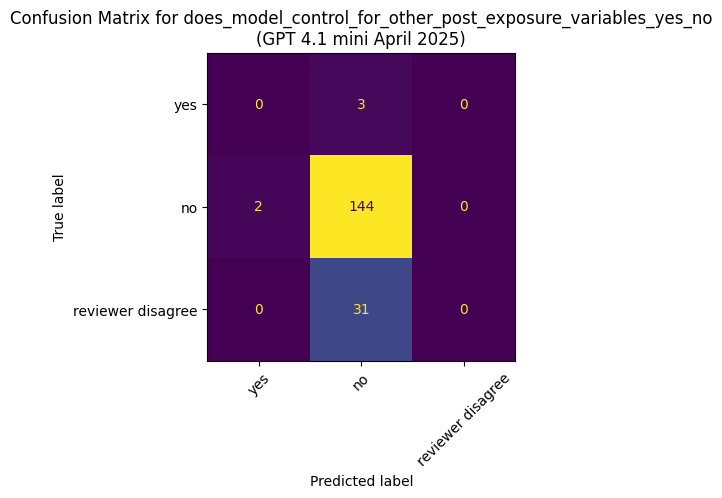


=== Overall Macro Average (Global across all fields) ===
Macro Precision: 0.032
Macro Recall:    0.046
Macro F1-score:  0.034

=== Overall Weighted Average (Global across all fields) ===
Weighted Precision: 0.720
Weighted Recall:    0.667
Weighted F1-score:  0.673


In [77]:
# truth_dict_all: pmid_number -> ground_truth_dict
# prediction_dict_all: pmid_number -> predicted_dict
#truth_dict_all = {entry['pmid_number']: entry for entry in merged_json_master_review}
results_df_41 = evaluate_binary_predictions_across_records(
    truth_dict_all=standardized_ground_truth,
    prediction_dict_all={k: json.loads(v) for k,v in gpt41_result_final.items()},
    model_name="GPT 4.1 mini April 2025"
)

In [78]:
# Open and load JSON manually
with open("/Users/yiquntchen/Dropbox/causaljudge-data/o4-mini_result_final.json", 'r') as f:
    mini_result_final = json.load(f)

In [81]:
import json

prediction_dict_all = {}

failed_pmids = []

for k, v in mini_result_final.items():
    try:
        if v is not None:
            prediction_dict_all[k] = json.loads(v)
        else:
            prediction_dict_all[k] = None
            failed_pmids.append(k)
    except Exception as e:
        prediction_dict_all[k] = None
        failed_pmids.append(k)
        print(f"Failed to load prediction for PMID {k}: {e}")

print(f"\nTotal failed pmids: {len(failed_pmids)}")


Total failed pmids: 1


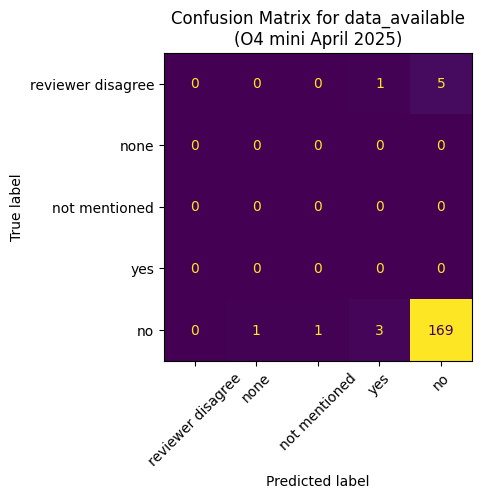

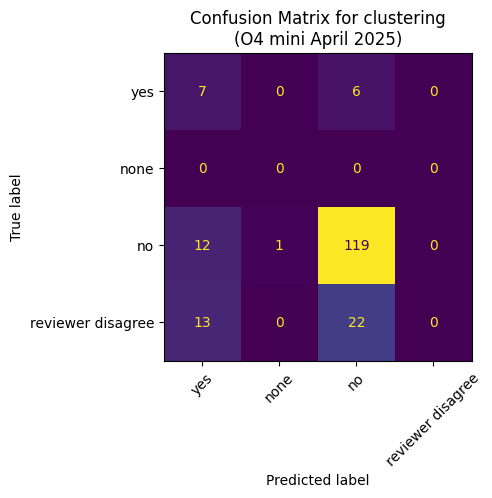

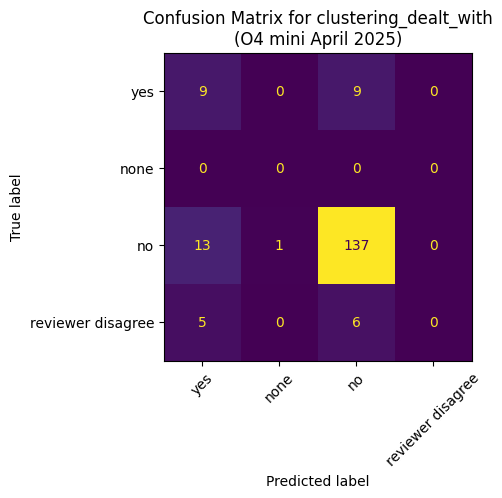

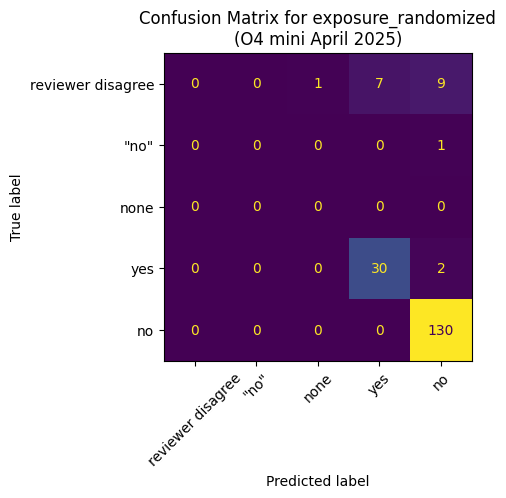

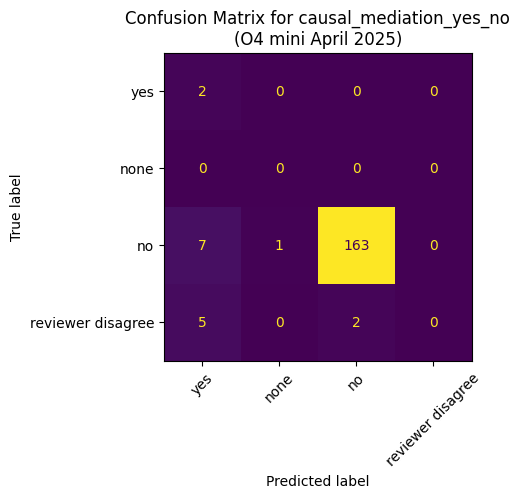

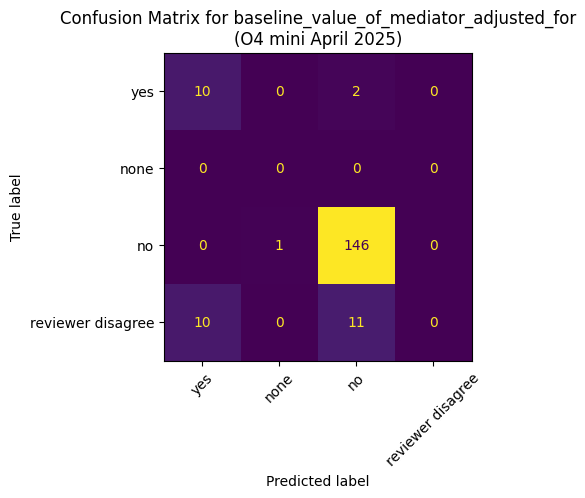

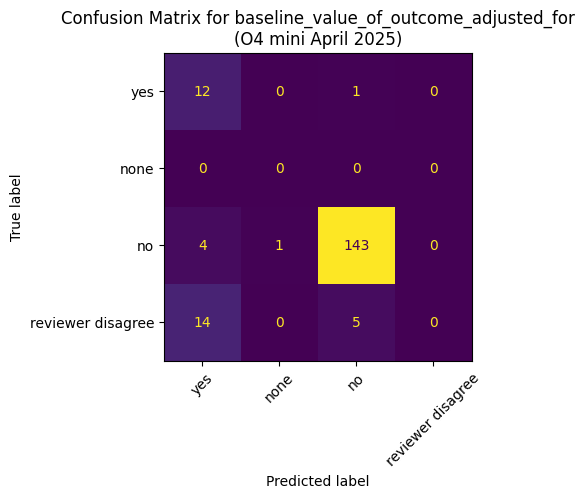

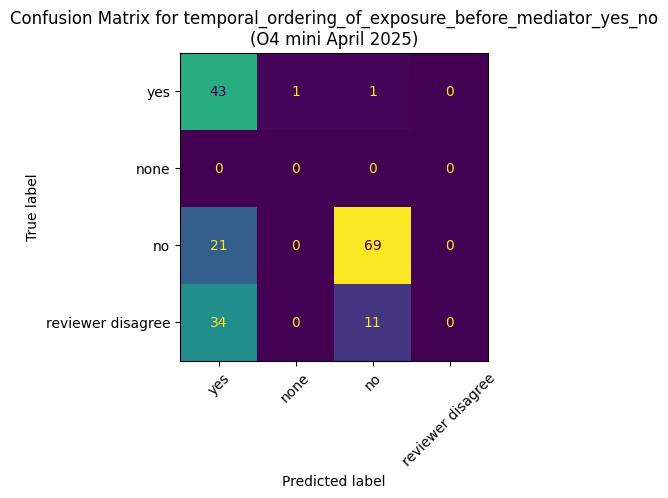

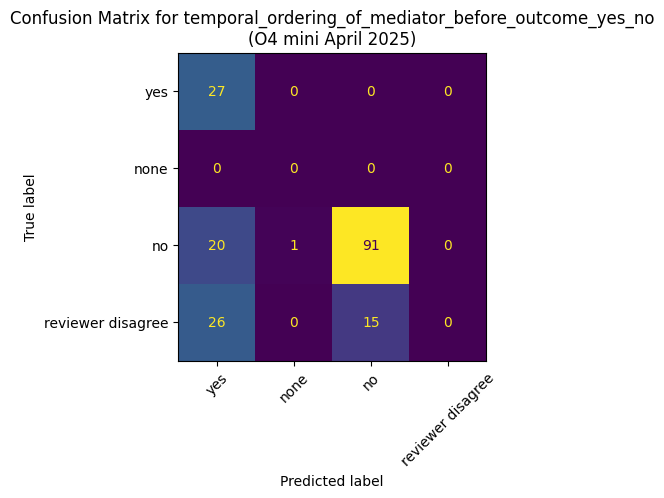

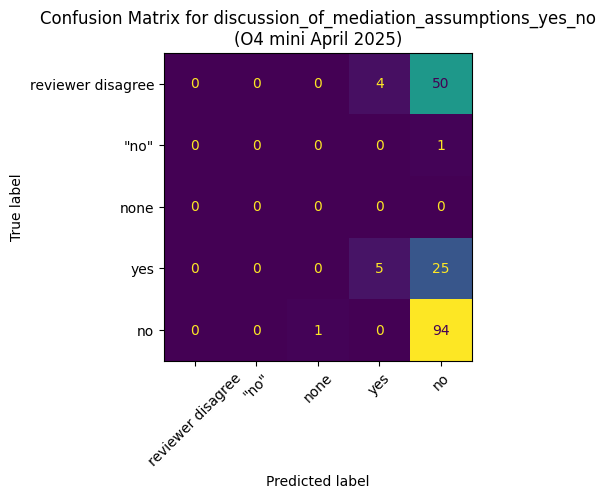

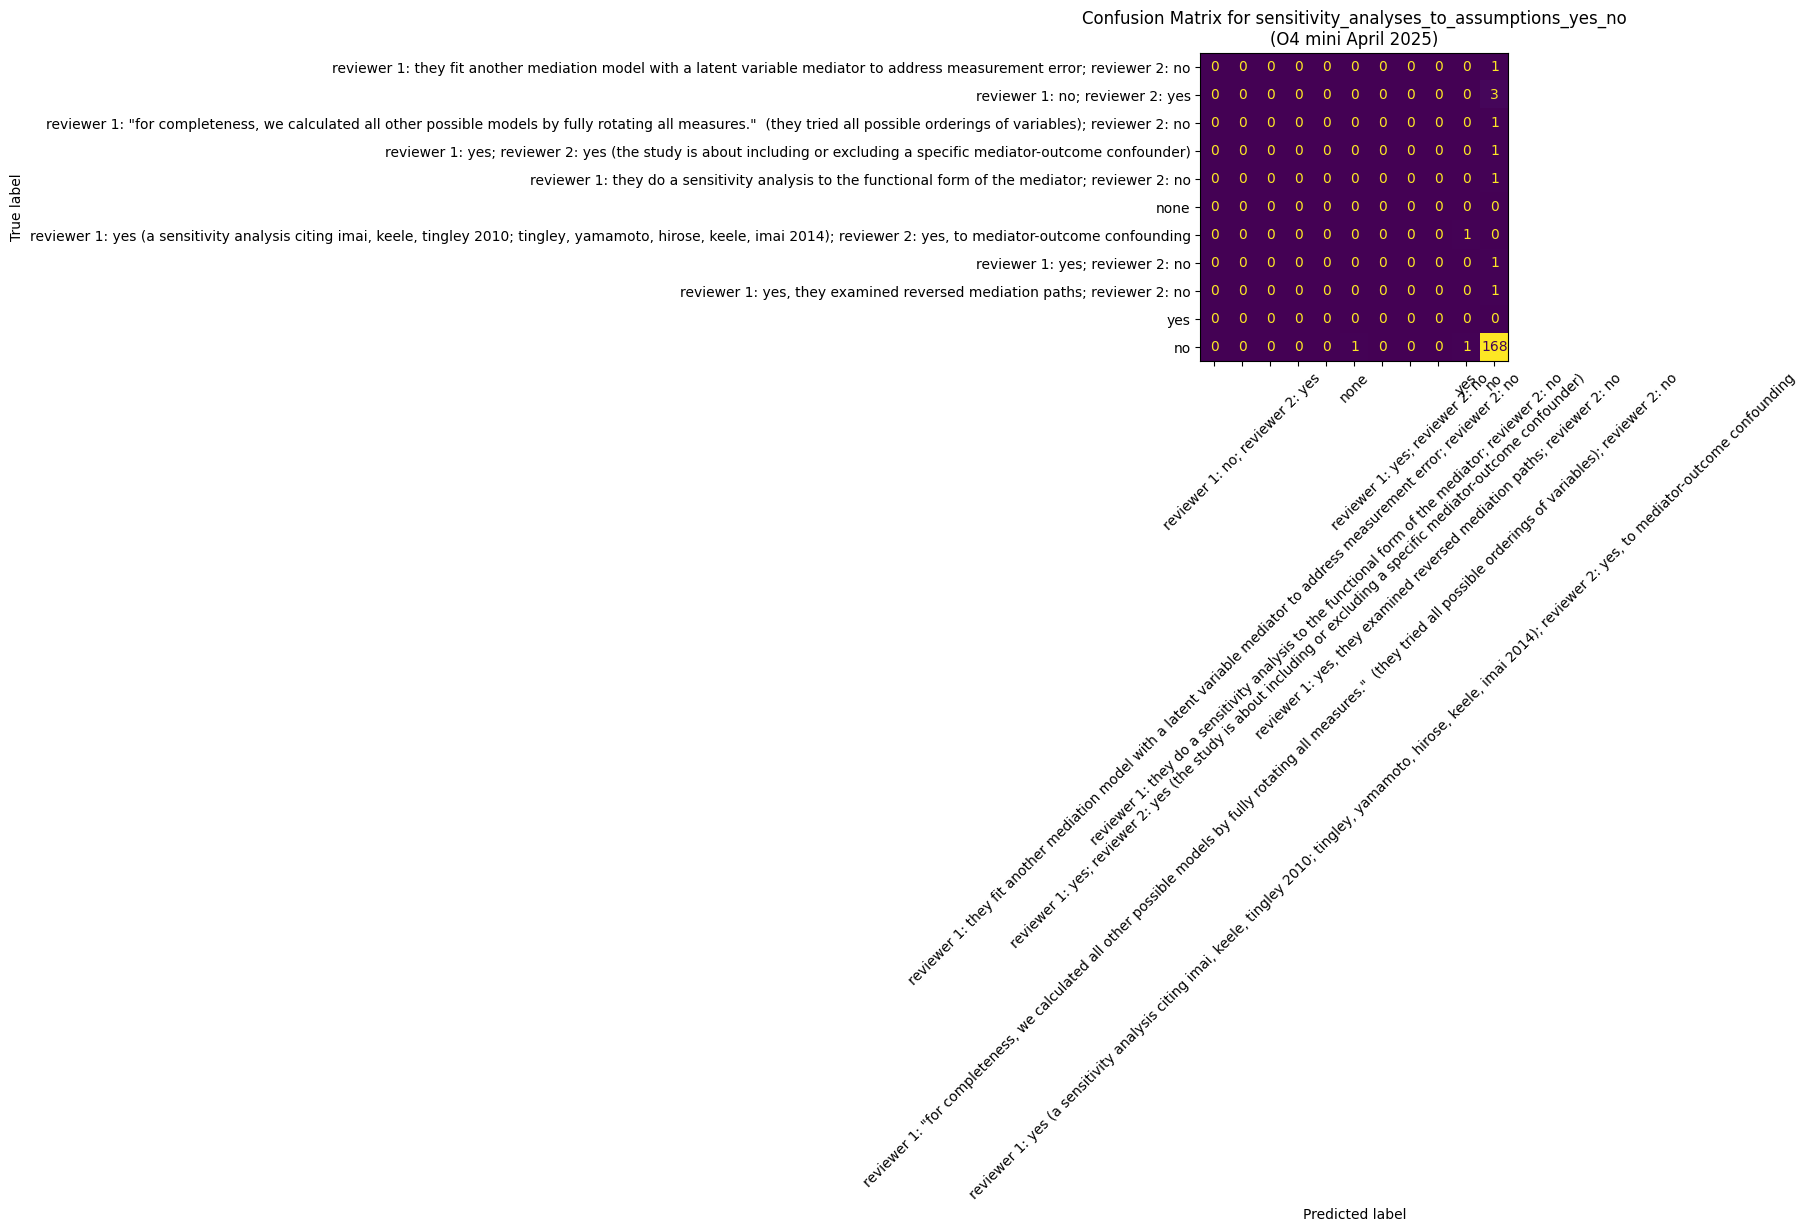

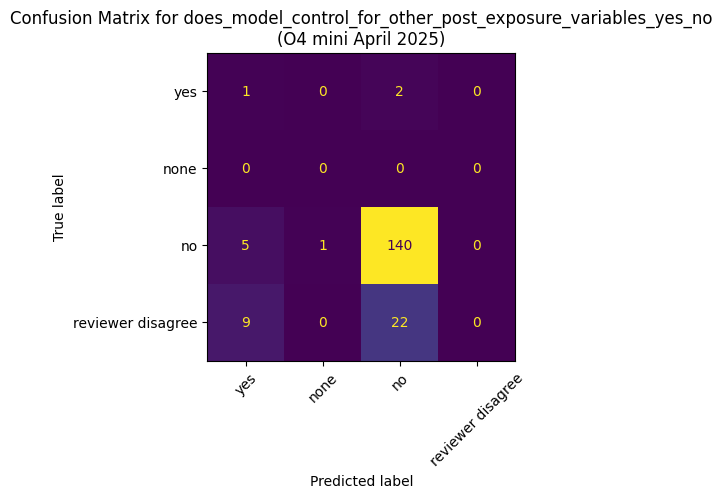


=== Overall Macro Average (Global across all fields) ===
Macro Precision: 0.092
Macro Recall:    0.121
Macro F1-score:  0.102

=== Overall Weighted Average (Global across all fields) ===
Weighted Precision: 0.714
Weighted Recall:    0.794
Weighted F1-score:  0.749


In [86]:
# truth_dict_all: pmid_number -> ground_truth_dict
# prediction_dict_all: pmid_number -> predicted_dict
#truth_dict_all = {entry['pmid_number']: entry for entry in merged_json_master_review}
results_df_o4mini = evaluate_binary_predictions_across_records(
    truth_dict_all=standardized_ground_truth,
    prediction_dict_all=prediction_dict_all,
    model_name="O4 mini April 2025"
)